In [ ]:
# TODO:
# change to Python 2
# re-label to hierarchy

In [1]:
# Python 3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import xmltodict
from os import listdir, mkdir, remove
from os.path import isdir, isfile, join
from shutil import copy, rmtree
%matplotlib inline

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [2]:
annot_dir = 'Annotations'
img_dir = 'JPEGImages'
single, overall = list(), list()
annot_files = listdir(annot_dir)
files_count = len(annot_files)
for i in range(0, files_count):
    with open(join(annot_dir, annot_files[i]), mode='r') as h:
        annot = xmltodict.parse(h.read())['annotation']
        if isinstance(annot['object'], list):
            img_name = annot['filename']
            obj_count = len(annot['object'])
            overall.append(np.array([img_name, obj_count]))
        else:  # contains one annotated object
            img_name = annot['filename']
            obj_class_name = annot['object']['name']
            box = annot['object']['bndbox']
            try:
                obj_size = (int(box['xmax']) - int(box['xmin'])) * (int(box['ymax']) - int(box['ymin']))
                img_size = int(annot['size']['width']) * int(annot['size']['height'])
            except:  # a few images contains non-integer bounding box and requires manual fix
                print(annot_files[i])
            obj_size_ratio = obj_size / img_size
            single.append(np.array([img_name, obj_class_name, obj_size_ratio]))
            overall.append(np.array([img_name, 1]))
        progress = int(float(i) / float(files_count) * 1000) / 10
        print('{}: {}%'.format(img_name, progress), end='\r')

In [3]:
col_names = ['img_name', 'obj_count']
overall_df = pd.DataFrame(overall, columns=col_names)
overall_df['obj_count'] = overall_df['obj_count'].astype('category')
print(overall_df.dtypes)
print(overall_df.head())

img_name       object
obj_count    category
dtype: object
          img_name obj_count
0  2009_001061.jpg         1
1  2012_002654.jpg         2
2  2008_006600.jpg         8
3  2010_002200.jpg         7
4  2011_002107.jpg         1


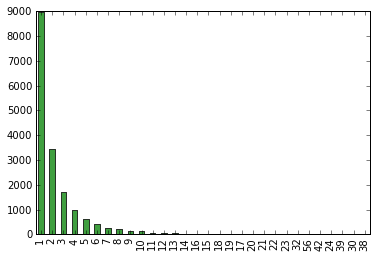

In [4]:
overall_df['obj_count'].value_counts().plot(kind='bar', color='green', alpha=0.75)#.get_figure().savefig('1.pdf')

In [5]:
col_names = ['img_name', 'obj_class_name', 'obj_size_ratio']
single_df = pd.DataFrame(single, columns=col_names)
single_df['obj_class_name'] = single_df['obj_class_name'].astype('category')
single_df['obj_size_ratio'] = single_df['obj_size_ratio'].astype('float32')
print(single_df.dtypes)
print(single_df.head())

img_name            object
obj_class_name    category
obj_size_ratio     float32
dtype: object
          img_name obj_class_name  obj_size_ratio
0  2009_001061.jpg      motorbike        0.995339
1  2011_002107.jpg      motorbike        0.947467
2  2008_005436.jpg            dog        0.606795
3  2012_003076.jpg         person        0.033536
4  2009_002712.jpg          train        0.468864


In [6]:
obj_class_names = set(single_df['obj_class_name'])
obj_class_name_index = dict(zip(list(obj_class_names), list(range(0, len(obj_class_names)))))
obj_class_name_index

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 6,
 'boat': 17,
 'bottle': 2,
 'bus': 3,
 'car': 4,
 'cat': 9,
 'chair': 11,
 'cow': 8,
 'diningtable': 13,
 'dog': 7,
 'horse': 12,
 'motorbike': 14,
 'person': 19,
 'pottedplant': 18,
 'sheep': 10,
 'sofa': 5,
 'train': 15,
 'tvmonitor': 16}

In [7]:
single_df['obj_class_index'] = np.array([obj_class_name_index[n] for n in single_df['obj_class_name']])
single_df['obj_class_index'] = single_df['obj_class_index'].astype('category')
print(single_df.dtypes)
print(single_df.head())

img_name             object
obj_class_name     category
obj_size_ratio      float32
obj_class_index    category
dtype: object
          img_name obj_class_name  obj_size_ratio obj_class_index
0  2009_001061.jpg      motorbike        0.995339              14
1  2011_002107.jpg      motorbike        0.947467              14
2  2008_005436.jpg            dog        0.606795               7
3  2012_003076.jpg         person        0.033536              19
4  2009_002712.jpg          train        0.468864              15


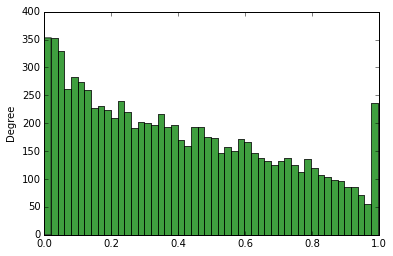

In [8]:
single_df['obj_size_ratio'].plot(kind='hist', color='green', bins=50, alpha=0.75)#.get_figure().savefig('2.pdf')

In [9]:
sdf_large_obj = single_df[single_df['obj_size_ratio'] >= 0.2]
sdf_lo_class_count = pd.DataFrame(sdf_large_obj['obj_class_name'].value_counts(), columns=['large_obj'])
sdf_lo_class_count['obj_class_name'] = sdf_lo_class_count.index
sdf_class_count = pd.DataFrame(single_df['obj_class_name'].value_counts(), columns=['original'])
sdf_class_count['obj_class_name'] = sdf_class_count.index
join_df = pd.merge(sdf_class_count, sdf_lo_class_count, on='obj_class_name')
join_df.index = join_df['obj_class_name']
join_df.index.name = ''
join_df.drop('obj_class_name', axis=1, inplace=True)

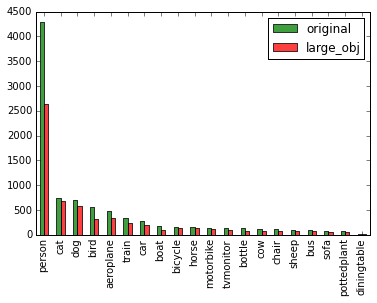

In [10]:
join_df.plot(kind='bar', color='green', alpha=0.75)#.get_figure().savefig('3.pdf')

In [11]:
sdf_lo_person_only = sdf_large_obj[sdf_large_obj["obj_class_name"] == "person"]
sdf_lo_no_person = sdf_large_obj.drop(sdf_lo_person_only.index)
sdf_lo_person_sample = sdf_large_obj.ix[random.sample(list(sdf_lo_person_only.index), 850)]
sdf_lo_balanced = pd.concat([sdf_lo_no_person, sdf_lo_person_sample], ignore_index=True)
print(sdf_lo_balanced.shape)
print(sdf_lo_balanced.dtypes)
print(sdf_lo_balanced.head())

(4384, 4)
img_name             object
obj_class_name     category
obj_size_ratio      float32
obj_class_index    category
dtype: object
          img_name obj_class_name  obj_size_ratio obj_class_index
0  2009_001061.jpg      motorbike        0.995339              14
1  2011_002107.jpg      motorbike        0.947467              14
2  2008_005436.jpg            dog        0.606795               7
3  2009_002712.jpg          train        0.468864              15
4  2010_002901.jpg            dog        0.328373               7


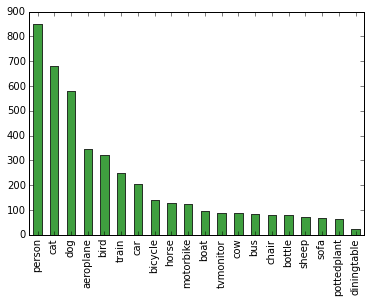

In [12]:
sdf_lo_balanced["obj_class_name"].value_counts().plot(kind="bar", color="green", alpha=0.75)#.get_figure().savefig('4.pdf')

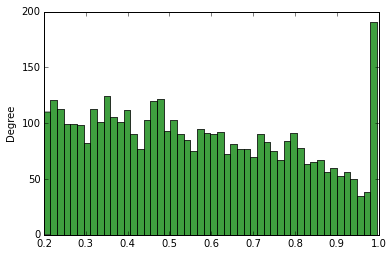

In [13]:
sdf_lo_balanced["obj_size_ratio"].plot(kind="hist", color="green", bins=50, alpha=0.75)

In [14]:
sdf_lob_shuffled = sdf_lo_balanced.reindex(np.random.permutation(sdf_lo_balanced.index))
n = sdf_lob_shuffled.shape[0]
sdf_lob_shuffled["split"] = np.array(["train"]*int(n/2) + ["val"]*int(n/4) + ["test"]*(n-int(n/2)-int(n/4)))
sdf_lob_shuffled["split"] = sdf_lob_shuffled["split"].astype("category")
sdf_lob_shuffled["path"] = sdf_lob_shuffled["split"] + np.array(["/"] * n) + sdf_lob_shuffled["img_name"]
print(sdf_lob_shuffled.dtypes)
print(sdf_lob_shuffled.head())

img_name             object
obj_class_name     category
obj_size_ratio      float32
obj_class_index    category
split              category
path                 object
dtype: object
             img_name obj_class_name  obj_size_ratio obj_class_index  split  \
1480  2011_001432.jpg           bird        0.699897               6  train   
2128  2009_002093.jpg            dog        0.520667               7  train   
3267  2009_000611.jpg      motorbike        0.816581              14  train   
1872  2010_001938.jpg            cat        0.994798               9  train   
986   2008_003048.jpg            cat        0.784821               9  train   

                       path  
1480  train/2011_001432.jpg  
2128  train/2009_002093.jpg  
3267  train/2009_000611.jpg  
1872  train/2010_001938.jpg  
986   train/2008_003048.jpg  


In [13]:
with open("preprocess.pickle", mode="wb") as h:
    pickle.dump(sdf_lob_shuffled, h, protocol=2)
for f in ["train", "val", "test"]:
    if isdir(f):
        rmtree(f)
    mkdir(f)
    if isfile(f + ".txt"):
        remove(f + ".txt")

In [14]:
img_name_list = sdf_lob_shuffled["img_name"]
obj_class_index_list = sdf_lob_shuffled["obj_class_index"]
split_list = sdf_lob_shuffled["split"]
to_path_list = sdf_lob_shuffled["path"]
split_path_class_index = {"train": [], "val": [], "test": []}
for i in range(0, n):
    copy(join(img_dir, img_name_list[i]), to_path_list[i])
    description = "{} {}\n".format(to_path_list[i], obj_class_index_list[i])
    split_path_class_index[split_list[i]].append(description)
    progress = int(float(i) / float(n) * 1000) / 10
    print("{}: {}%".format(img_name_list[i], progress), end="\r")
for f in ["train", "val", "test"]:
    with open(f + ".txt", mode="w") as h:
        h.writelines(split_path_class_index[f])